#### `confirm_wave_calcs` - Check my calcs with spotter data  
Based on code and advice from Isabel Houghton, Jake Davis, and Jim Thomson



In [25]:
import os
import pickle
from datetime import datetime, timezone
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.colors
import numpy as np

import xarray as xr
import xroms
import matplotlib.pyplot as plt
from wavespectra import read_ww3, read_swan, read_ndbc, read_netcdf
from roguewave.wavespectra.estimators.estimate import estimate_directional_distribution

%run -i wave_stats.py


#### Start by loading spotter data 

In [2]:
DATA_DIRECTORY = '/vortexfs1/home/csherwood/proj/NOPP/buoy_data/'
DATA_FILENAME = 'hurricane_ian_spotter_data_v1.pickle'
#MODEL_DIRECTORY = '/vortexfs1/scratch/jwarner/Ian2022/ian10/'
MODEL_DIRECTORY = '/vortexfs1/share/usgs-share/Projects/Ian2022/ian10/drifters/'

# This runs the file with the new ndbc buoy input
#%run -i /vortexfs1/home/csherwood/src/wavespectra/wavespectra/input/ndbc.py

with open(os.path.join(DATA_DIRECTORY, DATA_FILENAME), 'rb') as handle:
    spotter = pickle.load(handle)

# `spotter` is a python dictionary of Pandas DataFrames, keyed by
# each drifter ID. The drifter ids can then be accessed as follows:
spotter_ids = list(spotter.keys())

In [11]:
spotter_ids

['SPOT-30068D',
 'SPOT-30097D',
 'SPOT-30096D',
 'SPOT-30104D',
 'SPOT-30024D',
 'SPOT-30065D']

In [12]:
# pick one of the spotters
sid = spotter_ids[0]
# keep ones with wave data
only_waves = spotter[sid]['energy_density'].notnull()
spotter[sid][only_waves]

,latitude,longitude,significant_height,peak_period,peak_direction,peak_directional_spread,mean_period,mean_direction,mean_directional_spread,frequency,energy_density,a1,b1,a2,b2,wave_check_factor,sea_surface_temperature,sea_level_pressure
time,,,,,,,,,,,,,,,,,,
2022-09-27 00:35:55+00:00,26.04102,-82.43437,0.580,4.096,145.692,28.154,3.222,146.350,40.584,"[0.0293, 0.03906, 0.04883, 0.05859, 0.06836, 0...","[0.0032511999999999997, 0.003750912, 0.0040007...","[0.0, 0.035191, 0.043988, -0.057673, -0.172043...","[-0.062561, -0.00782, 0.021505, -0.017595, 0.0...","[-0.192571, -0.320626, -0.347996, -0.301075, -...","[0.26784, 0.353861, 0.454545, 0.329423, 0.1280...",NaN,30.62,1010.0
2022-09-27 01:35:55+00:00,26.04567,-82.43720,0.609,4.267,148.142,22.315,3.348,144.351,38.715,"[0.0293, 0.03906, 0.04883, 0.05859, 0.06836, 0...","[0.0055009279999999995, 0.006501376, 0.0047513...","[0.01564, -0.056696, -0.093842, -0.119257, -0....","[0.268817, 0.230694, 0.13783, 0.020528, 0.0234...","[-0.477028, -0.42522, -0.375367, -0.373412, -0...","[0.183773, 0.077224, 0.059629, -0.008798, 0.04...",NaN,30.62,1010.6
2022-09-27 02:35:55+00:00,26.04597,-82.43840,0.568,4.452,144.462,20.913,3.194,137.098,39.163,"[0.0293, 0.03906, 0.04883, 0.05859, 0.06836, 0...","[0.000750592, 0.003750912, 0.004000768, 0.0020...","[-0.108504, -0.086021, -0.045943, -0.136852, -...","[0.190616, 0.031281, 0.121212, 0.074291, 0.001...","[-0.110459, 0.053763, 0.009775, -0.010753, -0....","[-0.060606, -0.14565, -0.162268, -0.210166, -0...",NaN,30.64,1011.2
2022-09-27 03:35:55+00:00,26.04507,-82.44098,0.587,4.452,139.736,20.222,3.184,128.515,39.402,"[0.0293, 0.03906, 0.04883, 0.05859, 0.06836, 0...","[0.001000448, 0.004000768, 0.00775168, 0.00350...","[-0.043011, -0.074291, -0.059629, -0.100684, -...","[0.075269, 0.009775, -0.096774, 0.040078, 0.12...","[0.140762, 0.079179, -0.050831, 0.163245, 0.24...","[0.079179, -0.044966, -0.061584, 0.017595, -0....",NaN,30.58,1011.2
2022-09-27 04:35:55+00:00,26.04413,-82.44550,0.601,4.452,134.314,22.408,3.122,123.313,40.512,"[0.0293, 0.03906, 0.04883, 0.05859, 0.06836, 0...","[0.002250752, 0.005251072, 0.004501504, 0.0030...","[0.053763, 0.043988, -0.060606, -0.028348, -0....","[0.056696, 0.00782, 0.022483, -0.030303, 0.011...","[0.014663, -0.01955, -0.120235, -0.048876, 0.0...","[-0.203324, -0.216031, -0.071359, -0.073314, -...",NaN,30.54,1010.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-29 19:35:55+00:00,25.46642,-82.31495,2.410,9.309,319.038,19.450,6.510,318.958,28.064,"[0.0293, 0.03906, 0.04883, 0.05859, 0.06836, 0...","[0.01000448, 0.015001599999999999, 0.01375232,...","[0.047898, 0.132942, 0.308895, 0.281525, 0.360...","[-0.151515, -0.081134, -0.168133, -0.28348, -0...","[-0.328446, -0.26002, -0.066471, -0.02346, 0.1...","[-0.132942, -0.123167, -0.193548, -0.208211, -...",NaN,29.16,1005.8
2022-09-29 20:35:55+00:00,25.45828,-82.30228,2.346,7.877,319.581,20.700,6.317,319.848,28.144,"[0.0293, 0.03906, 0.04883, 0.05859, 0.06836, 0...","[0.00249856, 0.00249856, 0.00249856, 0.0024985...","[0.190616, 0.201369, 0.191593, 0.205279, 0.410...","[-0.111437, -0.135875, -0.233627, -0.304985, -...","[-0.264907, -0.195503, -0.004888, -0.083089, 0...","[-0.246334, -0.238514, -0.216031, -0.198436, -...",NaN,29.18,1005.5
2022-09-29 21:35:55+00:00,25.44680,-82.29533,2.270,9.309,316.766,15.225,6.121,320.335,28.607,"[0.0293, 0.03906, 0.04883, 0.05859, 0.06836, 0...","[0.00249856, 0.007500799999999999, 0.007500799...","[0.037146, 0.053763, 0.16129, 0.217009, 0.3636...","[0.016618, -0.13783, -0.352884, -0.327468, -0....","[0.062561, -0.125122, -0.349951, -0.235582, -0...","[-0.081134, -0.134897, -0.233627, -0.304008, -...",NaN,29.18,1005.7


### Three sources of stats for the drifters
1) Stats provided in dataset
2) Stats computed from native data (a1, a2, etc)
3) Stats computed from 2d spec (generated from a model like MEM)

In [4]:
# pick a time
time_index = 36

# pull arrays from the buoys
f  = spotter[sid][only_waves]['frequency'][time_index]
Ef = spotter[sid][only_waves]['energy_density'][time_index]
a1 = spotter[sid][only_waves]['a1'][time_index]
b1 = spotter[sid][only_waves]['b1'][time_index]
a2 = spotter[sid][only_waves]['a2'][time_index]
b2 = spotter[sid][only_waves]['b2'][time_index]
print('Shape of Ef:',np.shape(Ef))

# use model to make a 2dspec for spotter to compare round-tripping bulk stats
# this test with only a few angles works, and returns a 39 x 8 array before the transpose
# directions = np.linspace(22.5,360-22.5,8)
# directional_bin_width = 45.
directions = np.linspace(5, 355, 36 )
directional_bin_width = 10.
spotter_spectrum_mem2 = (
        estimate_directional_distribution(
            a1,
            b1,
            a2,
            b2,
            direction=directions,
            method="mem2",
        ).T
        * Ef
    )

# There is a lot I don't understnd about this estimate.
# * Why is radians to degrees called Jacobian
# * Does reshape always return [nf, ndir]?
#The output spectrum has four zeros on the end of the directional spectrum.
# print(spotter_spectrum_mem2)  
# this method of construction results in:
faxis = 1
daxis = 0
print('Shape of a1 etc',np.shape(a1))
print('Check shape of spectrum: ',np.shape(spotter_spectrum_mem2))
print('freq. axis = ',faxis,' direc. axis = ',daxis,', right?')

# convert back to a1, a2, (roundtrip)
# the 'atleast_2d' is needed to convert from (ndir,) to {ndir,1). I don't understand the difference.
directions_radians = (np.pi/180.) * np.atleast_2d(directions).T
Efr, a1r, a2r, b1r, b2r = to_Fourier( spotter_spectrum_mem2, spotter[sid][only_waves]['frequency'][time_index], directions_radians, directional_bin_width, faxis = faxis, daxis=daxis)

# first and second moments of 1D energy spectrum
m0 = np.trapz(Ef, f)
m1 = np.trapz(Ef * f, f)
m0r = np.trapz(Efr, f)
m1r = np.trapz(Efr * f, f)
print('Compare original Fourier with round-trip reconstructed Fourier: ')
print('First moments: ',m0,m0r)
integrated_a1 = np.trapz(a1 * Ef, f) / m0
integrated_b1 = np.trapz(b1 * Ef, f) / m0
integrated_a1r = np.trapz(a1r * Ef, f) / m0r
integrated_b1r = np.trapz(b1r * Ef, f) / m0r
print('Integrated a1, a1r:',integrated_a1, integrated_a1r)
print('Integrated b1, b1r:',integrated_b1, integrated_b1r)

Shape of Ef: (39,)
Shape of a1 etc (39,)
Check shape of spectrum:  (36, 39)
freq. axis =  1  direc. axis =  0 , right?
shape of Ef:  (36, 39)
shape of Ef:  (39,)
Compare original Fourier with round-trip reconstructed Fourier: 
First moments:  5.0802944822784 5.0802944822784
Integrated a1, a1r: 0.4956945958932658 0.4947559053989679
Integrated b1, b1r: -0.7198968571707902 -0.7186400894163228


In [5]:
# Why are the last two directional components zero?
print(spotter_spectrum_mem2)        

[[0.00149576 0.00346326 0.01116617 ... 0.         0.         0.        ]
 [0.00110962 0.00303555 0.00938411 ... 0.         0.         0.        ]
 [0.00078588 0.00251272 0.00757582 ... 0.         0.         0.        ]
 ...
 [0.00216938 0.00331443 0.01433192 ... 0.         0.         0.        ]
 [0.00212462 0.00362735 0.01378579 ... 0.         0.         0.        ]
 [0.00187033 0.00368269 0.0126976  ... 0.         0.         0.        ]]


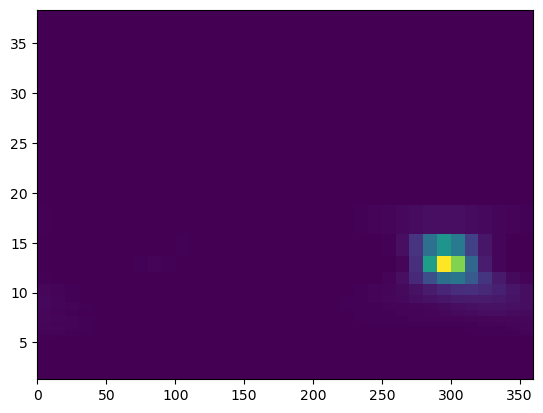

In [6]:
plt.pcolormesh(directions, 1./f, spotter_spectrum_mem2.T, shading='nearest')

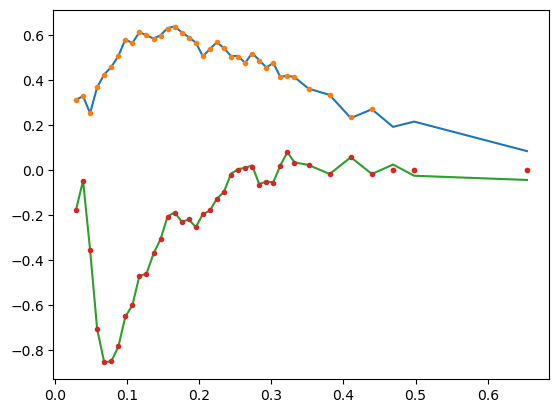

In [7]:
plt.plot(f,a1)
plt.plot(f,a1r,'.')
plt.plot(f,b1)
plt.plot(f,b1r,'.')

In [8]:
# Directional arrays (f)
D1 = (-180./np.pi)*np.arctan2(b1,a1)+90
D2 = (-180./np.pi)*0.5*np.arctan2(b2,a2)+90

# Spread1 seems to be the standard spreading parameter (O'Reilly et al., 1996; Jim Thomson's code...)
# Spread2 is an alternative proposed by O'Reilly et al. and appears in Jim Thomson's code
# Spread_alt is in Jim Thomson's code...not sure where it comes from
spread1 = (180./np.pi)*np.sqrt(2.*(1.-np.sqrt( a1**2 + b1**2)))
spread2 = (180./np.pi)*np.sqrt(np.abs( 0.5 - 0.5 * ( a2*np.cos(2.*D2) + b2*np.sin(2.*D2) )  ))
spread_alt = (180./np.pi)*np.sqrt(np.abs( 0.5 - 0.5 * ( a2**2 + b2**2 )  ))

# peak parameters
iEfmax = np.argmax(Ef)
Tp = 1./f[iEfmax]
Dp = D1[iEfmax]
S1p = spread1[iEfmax]
S2p = spread2[iEfmax]
Sap = spread_alt[iEfmax]

# standard bulk parameters
Hs = 4 * np.sqrt(m0)
# code from Isabel
Dm = np.arctan2(integrated_b1, integrated_a1) * 180 / np.pi
if(Dm<0.): Dm=Dm+360.
Tm = m0 / m1


spotter_spec1d = calc_spec1d_2d( spotter_spectrum_mem2, directional_bin_width, daxis=daxis )

In [9]:
# calc some bulk statistics based on the 2d spec
Hs_spec2d = calc_Hs_2d( spotter_spectrum_mem2, f, directional_bin_width, faxis=faxis, daxis=daxis )
TM01_spec2d = calc_TM01_2d( spotter_spectrum_mem2, f, directional_bin_width, faxis=faxis, daxis=daxis )
TM02_spec2d = calc_TM02_2d( spotter_spectrum_mem2, f, directional_bin_width, faxis=faxis, daxis=daxis )

H0_spec1d = 4.*np.sqrt( calc_m0_1d(  spotter_spec1d, f) )
FSPR = calc_FSPR_1d( spotter_spec1d, f, TM02_spec2d )

# Hs is very close
# Tp is exactly right
# Tm is very close
# Dm is off
# Dp is off by 180
# S1P is exactly right

# Don't have estimates of S1P or Saltp in spotter database
# Don't know how to calculate mean direction or mean directional spread
# Unsure of directional conventions
print('Hs: ', Hs, spotter[sid][only_waves]['significant_height'][time_index], Hs_spec2d, H0_spec1d)
print('Tp: ', Tp, spotter[sid][only_waves]['peak_period'][time_index])
print('Tm: ', Tm, spotter[sid][only_waves]['mean_period'][time_index])
print('TM01_2dspec: ', TM01_spec2d, 'TM02_2dspec: ',TM02_spec2d )
print('Dm: ', Dm, spotter[sid][only_waves]['mean_direction'][time_index])
print('Dp: ', Dp, spotter[sid][only_waves]['peak_direction'][time_index])
print('S1p:' , S1p,spotter[sid][only_waves]['peak_directional_spread'][time_index])
print('S2p, Saltp: ', S2p, Sap)
print('Sm',spotter[sid][only_waves]['mean_directional_spread'][time_index])
print('FSPR:', FSPR )

Hs:  9.015803442647494 9.019 9.015803442647492 9.015803442647494
Tp:  12.799180852425444 12.799
Tm:  10.917149188806732 10.919
TM01_2dspec:  10.91714918880673 TM02_2dspec:  10.337376223948196
Dm:  304.54987382307877 325.447
Dp:  151.6166252043084 331.617
S1p: 15.28381809832317 15.284
S2p, Saltp:  36.27974086930871 16.536906340771477
Sm 28.773
FSPR: 0.5444692299441017


In [26]:
print('Parameter       Provided          a1,a2,etc                2Dspec               Roundtrip (spec2d -> a1,a2,etc')

print('Hs (m):         {:8.3f}           {:8.3f}             {:8.3f}                 {:8.3f}'.format(
    spotter[sid][only_waves]['significant_height'][time_index],
    calc_Hs_1d( spotter[sid][only_waves]['energy_density'][time_index], f ),
    calc_Hs_2d( spotter_spectrum_mem2, f, directional_bin_width, faxis=faxis, daxis=daxis ),
    calc_Hs_1d( Efr, f) ) )

print('Dm (deg):       {:8.3f}           {:8.3f}             {:8.3f}                 {:8.3f}'.format(
    spotter[sid][only_waves]['mean_direction'][time_index],
    calc_theta_mean_a1b1( a1, b1, f),
    0.,
    calc_theta_mean_a1b1( a1r, b1r, f) ))

print('Dmw (deg):      {:8.3f}           {:8.3f}             {:8.3f}                 {:8.3f}'.format(
    spotter[sid][only_waves]['mean_direction'][time_index],
    calc_weighted_theta_mean_a1b1( a1, b1, spotter[sid][only_waves]['energy_density'][time_index], f),
    0.,
    calc_weighted_theta_mean_a1b1( a1r, b1r, Efr, f) ))

print('Sm (deg):      {:8.3f}           {:8.3f}             {:8.3f}                 {:8.3f}'.format(
    spotter[sid][only_waves]['mean_directional_spread'][time_index],
    calc_sigma_theta_a1b1( a1, b1, Ef, f ),
    0.,
    calc_sigma_theta_a1b1( a1r, b1r, Efr, f ) ))

Parameter       Provided          a1,a2,etc                2Dspec               Roundtrip (spec2d -> a1,a2,etc
Hs (m):            9.019              9.016                9.016                    9.016
Dm (deg):        325.447            290.577                0.000                  292.508
Dmw (deg):       325.447            325.450                0.000                  325.454
Sm (deg):        28.773             28.756                0.000                   28.935
